## Team Members

1. Siva Sai Kumari Maineni
2. Mahathi Mandapati
3. Yang Wang
4. Kang (Kevin) Hou
5. Kinnary Uday Panchal
6. Aboorva Erode Baskaran

**Imports**

In [18]:
#!/usr/bin/python3.6
#Install LDA library if not already installed
# pip3.6 install --user lda
# the input data file is natgeo_labels_2020.xlsx (a 2-column file with id as column 1 and text in column 2)
# there are two output files: topic_word_dist.xlsx and document_topic_dist.xlsx
# the script prompts for the name of the columns -- in the data file, I named them id and labels. You are then prompted for # topics. 4 or 5 may be a good starting point.



import os, csv, nltk, json, lda
import warnings
import pandas as pd
import numpy as np
import requests
import re

from os import listdir
from os.path import isfile, join
from collections import Counter
# Imports the Google Cloud client library
#from google.cloud import vision
import matplotlib.pyplot as plt
from nltk.tokenize import PunktSentenceTokenizer, RegexpTokenizer,word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict, cross_val_score



nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/kinnarypanchal/Downloads/uda-assignment-4-96341864fcec.json"

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Scraping**

##### **We have used the online scrapper call phantombuster to scrape the NatGeo insta page**

In [ ]:
df = pd.read_json('insta_post.json')
df_photo =  df[df['type'] == 'Photo']
# df_photo = df_photo.drop_duplicates(subset='postUrl', keep="first")
new_img_list =  df_photo['postUrl']

# This step enable us to access the image after the Instagram url expiration date
imgUrl_list =  [s + 'media/?size=l' for s in new_img_list]
len(imgUrl_list)
new_url_df = pd.DataFrame(imgUrl_list, columns=['url'])
df_photo['imgUrl'] = new_url_df['url'].values

df_photo.to_json('insta_post1.json', orient= 'records')

**Image Labeling**

In [ ]:
# Opening JSON file
f = open('insta_post1.json')
# returns JSON object as a dictionary
data = json.load(f)

In [ ]:
def detect_labels_uri(uri):
    """Detects labels in the file located in Google Cloud Storage or on the
    Web."""
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()
    image = vision.Image()
    image.source.image_uri = uri

    response = client.label_detection(image=image)
    labels = response.label_annotations
    
    lbs = list()
    scr = list()
    for label in labels:
        lbs.append(label.description)
        scr.append(label.score)
        
        
    return (lbs, scr)

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
pid = list()
for i in range(0,len(data)):
    pid.append(data[i]['postId'])

items = Counter(pid).keys()
print("No of unique items in the list are:", len(items))

url = list()
for i in range(0, len(data)):
    url.append(data[i]['imgUrl'])

items = Counter(url).keys()
print("No of unique items in the list are:", len(items))

In [ ]:
url = list()
for i in range(0, len(data)):
    url.append(data[i]['imgUrl'])

for i in range(0, len(data)):
    lbs, scr = detect_labels_uri(url[i])
    data[i]['labels'] = lbs 
    data[i]['score'] = scr

with open('insta_label_score.json', 'w') as json_file:
    json.dump(data, json_file)

### There are 675 different posts with 893 images in total. 
### However there are only 485 unique images used throughout all the 675 posts
### This implies multiple posts have same images

In [ ]:
cd /content/MyD

[Errno 2] No such file or directory: 'Mydrive'
/content


**Data Preperation**

In [ ]:
# reading data
f1 = open('insta_label_score.json')
dt = json.load(f1)

In [ ]:
lbs = list()
scr = list()
likeCount = list()
commentCount = list()
caption = list()
for i in range(0, len(data)):
    lbs.append(dt[i]['labels'])
    scr.append(dt[i]['score'])
    likeCount.append(dt[i]['likeCount'])
    commentCount.append(dt[i]['commentCount'])
    caption.append(dt[i]['caption'])

In [ ]:
df = pd.DataFrame(list(zip(url, lbs, scr, likeCount, commentCount, caption)), columns =['imgUrl','labels', 'score', 'likeCount', 'commentCount', 'caption']) 
df.head()

,imgUrl,labels,score,likeCount,commentCount,caption
0,https://www.instagram.com/p/Ckvlx4fA7ch/media/...,"[Temple, Sculpture, Statue, World, Art, Landma...","[0.8743597865104675, 0.8710590600967407, 0.865...",22920,217,"Photo by National Geographic on November 09, 2..."
1,https://www.instagram.com/p/Ckt9EF4AgD5/media/...,"[World, Font, Bedrock, Landscape, Natural land...","[0.898686408996582, 0.8260526657104492, 0.7738...",156864,801,"Photo by National Geographic on November 08, 2..."
2,https://www.instagram.com/p/CktA-_-Ae-l/media/...,"[Sky, Atmosphere, Building, Cloud, Skyscraper,...","[0.9685000777244568, 0.9481807947158813, 0.927...",135166,673,"Photo by National Geographic on November 08, 2..."
3,https://www.instagram.com/p/CkqtXRvApPf/media/...,"[Event, Flash photography, Darkness, Working a...","[0.7158313989639282, 0.693068265914917, 0.6923...",96861,1239,"Photo by National Geographic on November 07, 2..."
4,https://www.instagram.com/p/CkqtXRvApPf/media/...,"[Event, Flash photography, Darkness, Working a...","[0.7158313989639282, 0.693068265914917, 0.6923...",96861,1239,"Photo by National Geographic on November 07, 2..."


In [ ]:
df.to_csv('img_lbs_scr.csv')

**Creating the Engagement Column(Target)**

In [ ]:
df['normalizedLikeCount'] = df['likeCount']/(df['likeCount'].max())
df['normalizedCommentCount'] = df['commentCount']/(df['commentCount'].max())
df['engagementScore'] =  .4*df['normalizedLikeCount'] + .6*df['normalizedCommentCount']
df['engagement'] = df.apply(lambda x: 1 if x['engagementScore'] > df['engagementScore'].median() else 0, axis = 1)
df.head()

,imgUrl,labels,score,likeCount,commentCount,caption,normalizedLikeCount,normalizedCommentCount,engagementScore,engagement
0,https://www.instagram.com/p/Ckvlx4fA7ch/media/...,"[Temple, Sculpture, Statue, World, Art, Landma...","[0.8743597865104675, 0.8710590600967407, 0.865...",22920,217,"Photo by National Geographic on November 09, 2...",0.023917,0.004502,0.012268,0
1,https://www.instagram.com/p/Ckt9EF4AgD5/media/...,"[World, Font, Bedrock, Landscape, Natural land...","[0.898686408996582, 0.8260526657104492, 0.7738...",156864,801,"Photo by National Geographic on November 08, 2...",0.163685,0.016619,0.075445,1
2,https://www.instagram.com/p/CktA-_-Ae-l/media/...,"[Sky, Atmosphere, Building, Cloud, Skyscraper,...","[0.9685000777244568, 0.9481807947158813, 0.927...",135166,673,"Photo by National Geographic on November 08, 2...",0.141043,0.013963,0.064795,1
3,https://www.instagram.com/p/CkqtXRvApPf/media/...,"[Event, Flash photography, Darkness, Working a...","[0.7158313989639282, 0.693068265914917, 0.6923...",96861,1239,"Photo by National Geographic on November 07, 2...",0.101073,0.025706,0.055853,0
4,https://www.instagram.com/p/CkqtXRvApPf/media/...,"[Event, Flash photography, Darkness, Working a...","[0.7158313989639282, 0.693068265914917, 0.6923...",96861,1239,"Photo by National Geographic on November 07, 2...",0.101073,0.025706,0.055853,0


In [ ]:
df.to_csv('img_lbs_scr_with_engagement.csv')

## Task C - Topic Modeling

In [ ]:
def tokenize_text(version_desc):
    lowercase=version_desc.lower()
    text = wordnet_lemmatizer.lemmatize(lowercase)
    tokens = word_tokenizer.tokenize(text)
    return tokens

In [27]:
image_df = pd.read_csv("img_lbs_scr_with_engagement.csv")
image_df.reset_index(drop=True)
headerList = ['id', 'imgUrl', 'labels', 'score', 'likeCount', 'commentCount', 'caption', 'normalizedLikeCount', 'normalizedCommentCount', 'engagementScore', 'engagement']
image_df.to_csv("img_lbs_scr_with_engagement_mod.csv", header=headerList, index=False)
image_df = pd.read_csv("img_lbs_scr_with_engagement_mod.csv")


#checking for nulls if present any
print("Number of rows with any of the empty columns:")
print(image_df.isnull().sum().sum())
image_df = image_df.dropna()


Number of rows with any of the empty columns:
542
provide the column name for id: id
provide the column name for text: labels
Provide the number of latent topics: 5


<351x680 sparse matrix of type '<class 'numpy.int64'>'
	with 4046 stored elements in Compressed Sparse Row format>

In [28]:
# Removing stop words, punctuation and tokenizing
stop = stopwords.words('english')
## stop=stop+['photography']
image_df["labels"] = image_df["labels"].astype(str)
image_df["label_tokens"] = image_df["labels"].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
image_df["label_tokens"] = image_df["label_tokens"].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])
image_df

,id,imgUrl,labels,score,likeCount,commentCount,caption,normalizedLikeCount,normalizedCommentCount,engagementScore,engagement,label_tokens
0,0,https://www.instagram.com/p/Ckvlx4fA7ch/media/...,"['Temple', 'Sculpture', 'Statue', 'World', 'Ar...","[0.8743597865104675, 0.8710590600967407, 0.865...",22920,217,"Photo by National Geographic on November 09, 2...",0.023917,0.004502,0.012268,0,"[temple, sculpture, statue, world, art, landma..."
1,1,https://www.instagram.com/p/Ckt9EF4AgD5/media/...,"['World', 'Font', 'Bedrock', 'Landscape', 'Nat...","[0.898686408996582, 0.8260526657104492, 0.7738...",156864,801,"Photo by National Geographic on November 08, 2...",0.163685,0.016619,0.075445,1,"[world, font, bedrock, landscape, natural, lan..."
2,2,https://www.instagram.com/p/CktA-_-Ae-l/media/...,"['Sky', 'Atmosphere', 'Building', 'Cloud', 'Sk...","[0.9685000777244568, 0.9481807947158813, 0.927...",135166,673,"Photo by National Geographic on November 08, 2...",0.141043,0.013963,0.064795,1,"[sky, atmosphere, building, cloud, skyscraper,..."
3,3,https://www.instagram.com/p/CkqtXRvApPf/media/...,"['Event', 'Flash photography', 'Darkness', 'Wo...","[0.7158313989639282, 0.693068265914917, 0.6923...",96861,1239,"Photo by National Geographic on November 07, 2...",0.101073,0.025706,0.055853,0,"[event, flash, photography, darkness, working,..."
4,4,https://www.instagram.com/p/CkqtXRvApPf/media/...,"['Event', 'Flash photography', 'Darkness', 'Wo...","[0.7158313989639282, 0.693068265914917, 0.6923...",96861,1239,"Photo by National Geographic on November 07, 2...",0.101073,0.025706,0.055853,0,"[event, flash, photography, darkness, working,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
882,882,https://www.instagram.com/p/CeWVvyUOwZD/media/...,"['Water', 'Water resources', 'Tree', 'Fluvial ...","[0.9736745953559875, 0.9504656791687012, 0.874...",126378,541,"Photo by National Geographic on June 03, 2022....",0.131873,0.011225,0.059484,0,"[water, water, resources, tree, fluvial, landf..."
883,883,https://www.instagram.com/p/CeVzeHcMQPg/media/...,"['Eye', 'Frog', 'True frog', 'Plant', 'Toad', ...","[0.9400314688682556, 0.9166107177734375, 0.909...",107664,609,"Photo by National Geographic on June 03, 2022....",0.112345,0.012635,0.052519,0,"[eye, frog, true, frog, plant, toad, organism,..."
884,884,https://www.instagram.com/p/CeUTV9QOFtk/media/...,"['Sky', 'Cloud', 'Atmosphere', 'Natural landsc...","[0.9640792608261108, 0.949225664138794, 0.9481...",97542,512,"Photo by National Geographic on June 02, 2022....",0.101783,0.010623,0.047087,0,"[sky, cloud, atmosphere, natural, landscape, m..."
888,888,https://www.instagram.com/p/CeTOrRksjrV/media/...,"['Bird', 'Water', 'Sky', 'Body of water', 'Mor...","[0.9773615002632141, 0.9736226201057434, 0.969...",101698,592,"Photo by National Geographic on June 02, 2022....",0.106120,0.012283,0.049818,0,"[bird, water, sky, body, water, morning, beach..."


In [30]:
labels_list = image_df['labels']

label_to_sentence = []

for labels_word in labels_list:
  labels_word = labels_word[1:]
  labels_word = labels_word[:-1]
  cur_label = re.sub(r'[^\w\s]', '', labels_word)
  label_to_sentence.append(cur_label)


id_column = input('provide the column name for id: ')
labels_column = input('provide the column name for text: ')
ntopics= input('Provide the number of latent topics: ');


word_tokenizer=RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_nltk=set(stopwords.words('english'))


vec_words = CountVectorizer(tokenizer=tokenize_text,stop_words=stopwords_nltk,decode_error='ignore')
total_features_words = vec_words.fit_transform(label_to_sentence)
total_features_words
print(total_features_words.shape)

model = lda.LDA(n_topics=int(ntopics), n_iter=500, random_state=1)
lda_train = model.fit(total_features_words)

topic_word = model.topic_word_
doc_topic=model.doc_topic_
doc_topic=pd.DataFrame(doc_topic)
image_df = image_df.join(doc_topic)
doc_topic_df = pd.DataFrame()

for i in range(int(ntopics)):
    topic="topic_"+str(i)
    doc_topic_df[topic]=image_df.groupby([id_column])[i].mean()



provide the column name for id: id
provide the column name for text: labels
Provide the number of latent topics: 5


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  % sorted(inconsistent)


(351, 680)


,0,1,2,3,4
accessory,0.005804,0.000017,0.000009,0.000013,0.000014
accipitriformes,0.000008,0.003491,0.000009,0.000013,0.000014
adaptation,0.004976,0.000017,0.000009,0.000013,0.018355
adventure,0.000008,0.000017,0.001816,0.000013,0.000014
advertising,0.000836,0.000017,0.000009,0.000013,0.000014
...,...,...,...,...,...
yellow,0.004976,0.000017,0.000009,0.000013,0.000014
youth,0.000836,0.000017,0.000009,0.000013,0.000014
zebra,0.000008,0.000017,0.000009,0.000013,0.001425
zone,0.000008,0.000017,0.000009,0.001266,0.000014


In [50]:

topic_words_df = doc_topic_df.reset_index()
topics = pd.DataFrame(topic_word)
topics.columns = vec_words.get_feature_names()
topics1 = topics.transpose()



print ("Topics word distribution written in file topic_word_dist.xlsx ")
topics1.to_excel("topic_word_dist.xlsx")
doc_topic_df.to_excel("document_topic_dist.xlsx",index=False)
print ("Document topic distribution written in file document_topic_dist.xlsx ")

,words,t0,t1,t2,t3
accessory,0.005804,0.000017,0.000009,0.000013,0.000014
accipitriformes,0.000008,0.003491,0.000009,0.000013,0.000014
adaptation,0.004976,0.000017,0.000009,0.000013,0.018355
adventure,0.000008,0.000017,0.001816,0.000013,0.000014
advertising,0.000836,0.000017,0.000009,0.000013,0.000014
...,...,...,...,...,...
yellow,0.004976,0.000017,0.000009,0.000013,0.000014
youth,0.000836,0.000017,0.000009,0.000013,0.000014
zebra,0.000008,0.000017,0.000009,0.000013,0.001425
zone,0.000008,0.000017,0.000009,0.001266,0.000014


In [68]:
topics_rank = pd.read_excel('topic_word_dist.xlsx')
topics_rank

# topic 0
topic0 = dict(zip(topics_rank['Unnamed: 0'],topics_rank[0]))
topic0 = sorted(topic0.items(), key = lambda x:-x[1])


# topic 1
topic1 = dict(zip(topics_rank['Unnamed: 0'],topics_rank[1]))
topic1 = sorted(topic1.items(), key = lambda x:-x[1])

# topic 2
topic2 = dict(zip(topics_rank['Unnamed: 0'],topics_rank[2]))
topic2 = sorted(topic2.items(), key = lambda x:-x[1])

# topic 3
topic3 = dict(zip(topics_rank['Unnamed: 0'],topics_rank[3]))
topic3 = sorted(topic3.items(), key = lambda x:-x[1])

# topic 4
topic4 = dict(zip(topics_rank['Unnamed: 0'],topics_rank[4]))
topic4 = sorted(topic4.items(), key = lambda x:-x[1])



print(topic0[:10]) # fashion art desgin photography 
print(topic1[:10]) # animal and plant photography
print(topic2[:10]) # landscape with natural sence like water, mountain, and sky
print(topic3[:10]) # landscape with plant, nature sence, people, sky
print(topic4[:10]) # landscape with wildlife and green 


[('photography', 0.03064249047855606), ('event', 0.0289865871833085), ('art', 0.02567478059281339), ('flash', 0.02484682894518961), ('blue', 0.02319092564994205), ('electric', 0.02070707070707071), ('font', 0.02070707070707071), ('design', 0.01987911905944693), ('fashion', 0.0173952641165756), ('gesture', 0.01573936082132804)]
[('plant', 0.08511635984716916), ('terrestrial', 0.07469607502605072), ('bird', 0.04343522056269539), ('animal', 0.03996179228898924), ('beak', 0.02259465092045849), ('dog', 0.02259465092045849), ('monochrome', 0.01912122264675235), ('photography', 0.01912122264675235), ('reptile', 0.01912122264675235), ('black', 0.01738450850989927)]
[('landscape', 0.1021051680520419), ('sky', 0.06867546078785688), ('water', 0.06235092157571376), ('natural', 0.05602638236357065), ('cloud', 0.04157029273581495), ('mountain', 0.03163173111673292), ('landforms', 0.02440368630285508), ('phenomenon', 0.02440368630285508), ('slope', 0.02078966389591615), ('bedrock', 0.0189826526924466

In [54]:
doc_topic_df.head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4
id,,,,,
0,0.878261,0.008696,0.095652,0.008696,0.008696
1,0.008696,0.008696,0.965217,0.008696,0.008696
2,0.008696,0.008696,0.878261,0.008696,0.095652
3,0.903448,0.006897,0.006897,0.006897,0.075862
4,0.903448,0.006897,0.006897,0.006897,0.075862
5,0.834483,0.006897,0.006897,0.006897,0.144828
6,0.961905,0.009524,0.009524,0.009524,0.009524
7,0.248000,0.168000,0.008000,0.568000,0.008000
8,0.168000,0.008000,0.088000,0.728000,0.008000


In [ ]:
df_nat_final = pd.concat([image_df.reset_index(drop=True), doc_topic_df.reset_index(drop=True)], axis=1)


q1=np.percentile(df_nat_final.engagementScore, 25) 
q2=np.percentile(df_nat_final.engagementScore, 50)  
q3=np.percentile(df_nat_final.engagementScore, 75)

top_quartile=df_nat_final[df_nat_final['engagementScore']>q3]
top_quartile.count()

average_topic_weights_top = top_quartile[["topic_0",'topic_1',"topic_2",'topic_3',"topic_4"]].mean(axis=0)

bottom_quartile=df_nat_final[df_nat_final['engagementScore']<q1]
bottom_quartile.count()

average_topic_weights_bot = bottom_quartile[["topic_0",'topic_1',"topic_2",'topic_3',"topic_4"]].mean(axis=0)

quartile_topics = pd.concat([average_topic_weights_top,average_topic_weights_bot],axis=1)
quartile_topics.columns = ['Top Quartile','Bottom Quartile']

,id,imgUrl,labels,score,likeCount,commentCount,caption,normalizedLikeCount,normalizedCommentCount,engagementScore,...,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0,https://www.instagram.com/p/Ckvlx4fA7ch/media/...,"['Temple', 'Sculpture', 'Statue', 'World', 'Ar...","[0.8743597865104675, 0.8710590600967407, 0.865...",22920,217,"Photo by National Geographic on November 09, 2...",0.023917,0.004502,0.012268,...,0.008333,0.008333,0.008333,0.841667,0.008333,0.008333,0.008333,0.008333,0.091667,0.008333
1,1,https://www.instagram.com/p/Ckt9EF4AgD5/media/...,"['World', 'Font', 'Bedrock', 'Landscape', 'Nat...","[0.898686408996582, 0.8260526657104492, 0.7738...",156864,801,"Photo by National Geographic on November 08, 2...",0.163685,0.016619,0.075445,...,0.008333,0.008333,0.008333,0.258333,0.008333,0.008333,0.675000,0.008333,0.008333,0.008333
2,2,https://www.instagram.com/p/CktA-_-Ae-l/media/...,"['Sky', 'Atmosphere', 'Building', 'Cloud', 'Sk...","[0.9685000777244568, 0.9481807947158813, 0.927...",135166,673,"Photo by National Geographic on November 08, 2...",0.141043,0.013963,0.064795,...,0.008333,0.008333,0.091667,0.675000,0.008333,0.008333,0.008333,0.008333,0.008333,0.175000


In [ ]:
average_topic_weights_top

In [ ]:
average_topic_weights_bot

In [ ]:
quartile_topics

**Modeling**

**Reading the Labeled data**

In [32]:
df = pd.read_csv('img_lbs_scr_with_engagement.csv') \
       .drop(['Unnamed: 0'], axis=1)

df['imgUrl'] = df['imgUrl'].apply(lambda x: x.split('media')[0])
print(df.columns)
print(df.shape)


df2 = pd.DataFrame(columns=['img_url', 'description'])
# Opening JSON file
f = open('insta_post1.json')  
# returns JSON object as  a dictionary
data = json.load(f)
# Iterating through the json list
for descr in data:
    df2 = df2.append({'img_url': descr['postUrl'], 'description': descr['description'] }, ignore_index=True)
f.close()

print(df.shape, df2.shape)

descr_lookup = df2.set_index('img_url').to_dict()['description']
df['description'] = df.apply(lambda row: descr_lookup[row['imgUrl']], axis=1)

Index(['imgUrl', 'labels', 'score', 'likeCount', 'commentCount', 'caption',
       'normalizedLikeCount', 'normalizedCommentCount', 'engagementScore',
       'engagement'],
      dtype='object')
(893, 10)
(893, 10) (893, 2)


**Processing the data**

In [33]:
stemmer = SnowballStemmer("english")
stop = stopwords.words('english')

def remove_punctuation(s):
    """
    function to remove punctuations in a 
    sentence
    """
    string_punctuation = '''()-[]{};:'"\,<>./?@#$%^&*_~1234567890'''
    no_punct = ""
    for letter in s:
        if letter not in string_punctuation:
            no_punct += letter
    return no_punct

# Define function to lemmatize each word with its POS tag

# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
    
def lemmetization(pos_tagged_words):
    lemmatized_sentence = []
    for word, tag in pos_tagged_words:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

    
    
    
# removing unnecessary characters
df['description'] = df['description'].apply(lambda x: x.lower().split('|')[-1] \
                                                       .replace('\n', '') \
                                                       .replace('“', '') \
                                                       .replace('”', ''))
# removing punctuations in a sentence
i = 0
for row in df['description']:
    df.iloc[ i, -1] = remove_punctuation(row)
    i=i+1
    
df['description'] = df['description'].apply(word_tokenize)
df['description'] = df['description'].apply(lambda x : [w for w in x if w not in stop])

# df['description'] = df['description'].apply(lambda x: [stemmer.stem(y) for y in x])
# df['description'] = df['description'].apply(lambda x : " ".join(x))

lemmatizer = WordNetLemmatizer()
df['description'] = df['description'].apply(lambda x: nltk.pos_tag(x))
df['description'] = df['description'].apply(lambda words: list(map(lambda x: (x[0], pos_tagger(x[1])), words)))
df['description'] = df['description'].apply(lambda pos_tagged_words: lemmetization(pos_tagged_words))


Text_Column = list(df['description'].copy())
sklearn_tfidf = TfidfVectorizer(min_df=.01, max_df =.95, stop_words="english",use_idf=True, smooth_idf=False, sublinear_tf=True)
sklearn_representation = sklearn_tfidf.fit_transform(Text_Column)
Tfidf_Output = pd.DataFrame(sklearn_representation.toarray(), columns=sklearn_tfidf.get_feature_names())

final_data = pd.concat([Tfidf_Output, df[['imgUrl', 'engagement']]], axis=1)
final_data.drop_duplicates(inplace=True)
print(final_data.shape)

(485, 1388)


In [34]:
#Plotting Confusion Matrix
def show_confusion_matrix(C,class_labels=['0','1']):

    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."

    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            '%d'%(tn),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            '%d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            '%d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            '%d'%(tp),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'Error: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'Error: %.2f'%(fn / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,' ',
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            ' ',
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()

**With Description**

CV  accuracy 0.6742268041237114
CV auc score 0.6731194502092335


C:\Users\shiva\AppData\Local\Temp\ipykernel_10984\4126636653.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(class_labels + [''],rotation=90)


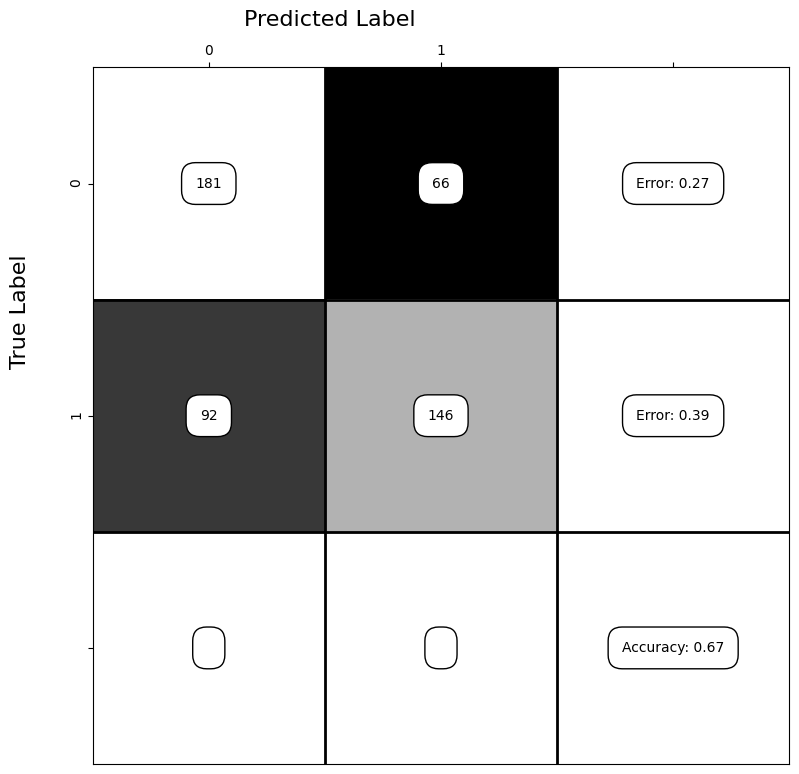

<Figure size 640x480 with 0 Axes>

In [35]:
selected_features = [col for col in final_data.columns if col not in ['imgUrl', 'engagement']]
X = final_data[selected_features]
Y = final_data['engagement']

#Logit Regression
classifier = LogisticRegression()
classifier.fit(X, Y)
Y_pred = cross_val_predict(classifier, X, Y, cv=5)

# calculating CV accuracy
cv_scores = cross_val_score(classifier, X, Y, cv=5)
print("CV  accuracy", sum(cv_scores) / len(cv_scores))

# calculating CV roc_roc
cv_scores = cross_val_score(classifier, X, Y, cv=5, scoring='roc_auc')
print("CV auc score", roc_auc_score(Y, Y_pred))

# calculating confusion matrix
cm = confusion_matrix(Y, Y_pred)
show_confusion_matrix(cm, ['0', '1'])
plt.show()
plt.savefig('Confusion.png')

In [39]:
coefs = classifier.coef_[0]
top_2_idx = np.argsort(coefs)[-5:]
top_2_values = [coefs[i] for i in top_2_idx]
print(top_2_values)
list1=[]
for i in range(0,len(classifier.coef_[0])):
    if classifier.coef_[0][i] in top_2_values:
        print(selected_features[i], classifier.coef_[0][i])

[0.8429533657490804, 0.8466444795286394, 0.851220343374101, 1.185151678932397, 1.2245397463935723]
animal 0.8466444795286394
javieraznarphotography 0.8429533657490804
lion 1.2245397463935723
wild 1.185151678932397
wildlife 0.851220343374101


**With Image Labels**

C:\Users\shiva\AppData\Local\Temp\ipykernel_10984\4126636653.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(class_labels + [''],rotation=90)


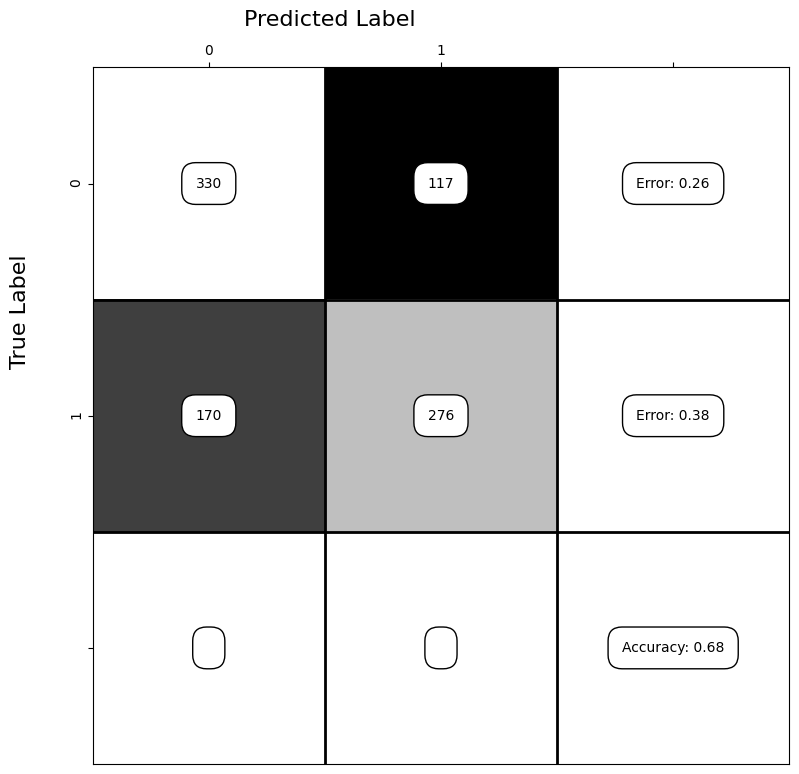

0.6785445571372679


<Figure size 640x480 with 0 Axes>

In [36]:
df['labels']=df['labels'].str.split(',').apply(lambda x : ("".join(x)).replace("'",''))
df['labels']=df['labels'].str[1:-1]
Text_Column=df['labels']
sklearn_tfidf = TfidfVectorizer(min_df=.01, max_df =.95, stop_words="english",use_idf=True, smooth_idf=False, sublinear_tf=True)
sklearn_representation = sklearn_tfidf.fit_transform(Text_Column)
Tfidf_Output = pd.DataFrame(sklearn_representation.toarray(), columns=sklearn_tfidf.get_feature_names())


Input = pd.concat([df, Tfidf_Output], axis=1)
Input=Input.drop(['labels', 'score', 'likeCount', 'commentCount', 'caption',
       'normalizedLikeCount', 'normalizedCommentCount', 'engagementScore','description'], axis=1)

selected_features2 = [col for col in Input.columns if col not in ['imgUrl', 'engagement']]

X = Input.loc[:, selected_features2]
Y = Input['engagement']
classifier2 = LogisticRegression()
classifier2.fit(X, Y)
Y_pred = cross_val_predict(classifier2, X, Y, cv=5)
cm = confusion_matrix((np.array(Y)), Y_pred)

show_confusion_matrix(cm, ['0', '1'])
plt.show()
plt.savefig('Confusion_matrix_for_Description_model.png')

print(roc_auc_score(Y, Y_pred))

In [41]:
coefs = classifier2.coef_[0]
top_2_idx = np.argsort(coefs)[-5:]
top_2_values = [coefs[i] for i in top_2_idx]
print(top_2_values)
list1=[]
for i in range(0,len(classifier2.coef_[0])):
    if classifier2.coef_[0][i] in top_2_values:
        print(selected_features2[i], classifier2.coef_[0][i])

[1.5372932057540034, 1.758968475604555, 1.7960313450237417, 2.076934250450233, 2.15630945061955]
atmosphere 1.7960313450237417
carnivore 2.15630945061955
ecoregion 1.5372932057540034
fawn 2.076934250450233
toy 1.758968475604555


**using both labels and description**

In [37]:
common_cols = list(set(selected_features).intersection(set(selected_features2)))
Input2 = pd.merge(Input, final_data.drop(['engagement']+common_cols, axis=1))
selected_features3 = [col for col in Input2.columns if col not in ['engagement', 'imgUrl']]

<function confusion_matrix at 0x000002CD18EFDE10>


C:\Users\shiva\AppData\Local\Temp\ipykernel_10984\4126636653.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(class_labels + [''],rotation=90)


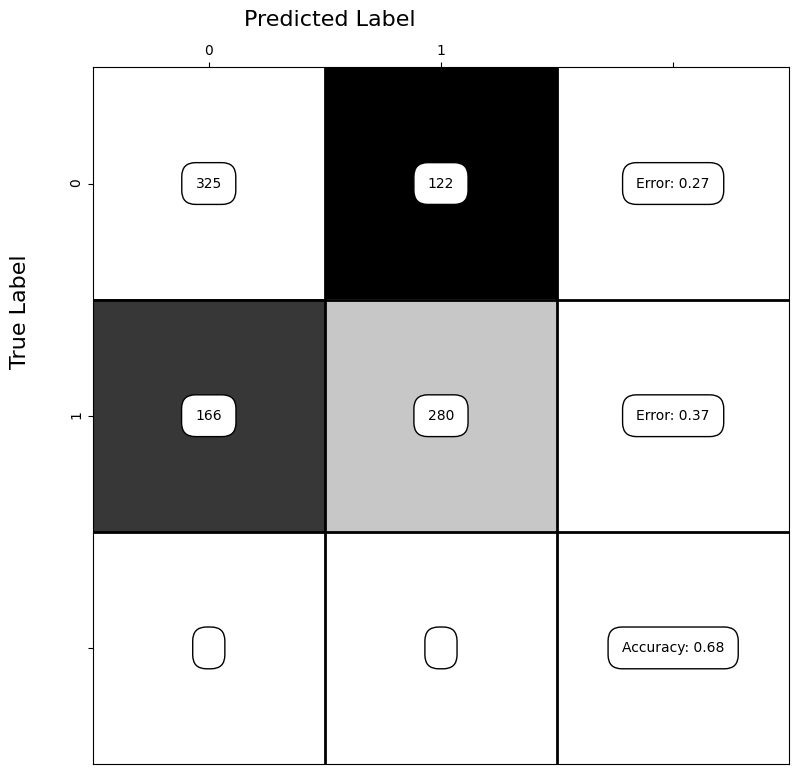

<Figure size 640x480 with 0 Axes>

In [38]:
X2 = Input2.loc[:, selected_features3]
Y2 = Input2['engagement']
classifier3 = LogisticRegression()
classifier3.fit(X2, Y2)
Y_pred2 = cross_val_predict(classifier3, X2, Y2, cv=5)
cm = confusion_matrix((np.array(Y2)), Y_pred2)
print(confusion_matrix)

show_confusion_matrix(cm, ['0', '1'])
plt.show()
plt.savefig('Confusion_for_model_with_descr_imglabels.png')

In [ ]:
coefs=clf.coef_[0]
top_2_idx = np.argsort(coefs)[-5:]
top_2_values = [coefs[i] for i in top_2_idx]
print(top_2_values)
list1=[]
for i in range(0,len(clf.coef_[0])):
    if clf.coef_[0][i] in top_2_values:
        list1.append(i)
print(list1)

In [42]:
coefs = classifier3.coef_[0]
top_2_idx = np.argsort(coefs)[-5:]
top_2_values = [coefs[i] for i in top_2_idx]
print(top_2_values)
list1=[]
for i in range(0,len(classifier3.coef_[0])):
    if classifier3.coef_[0][i] in top_2_values:
        print(selected_features3[i], classifier3.coef_[0][i])

[1.3838128189823387, 1.4932843809122536, 1.5019296845563288, 1.5462841169796069, 1.68908385354204]
atmosphere 1.5019296845563288
carnivore 1.68908385354204
ecoregion 1.3838128189823387
fawn 1.5462841169796069
toy 1.4932843809122536
